<a href="https://colab.research.google.com/github/me-kbs/it-cert-automation-practice/blob/master/CDusingTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install preprocessing

     |████████████████████████████████| 358kB 10.2MB/s 
     |████████████████████████████████| 1.4MB 10.9MB/s 
     |████████████████████████████████| 1.2MB 37.4MB/s 
  Created wheel for nltk: filename=nltk-3.2.4-cp37-none-any.whl size=1367706 sha256=d8bbc3b0f9297a9704f60e0bcc2a55a61209c35727fcfabb152929d89a746378
  Stored in directory: /root/.cache/pip/wheels/36/f1/5c/f667347d86a3a534ba4c0127eed4389f929916e3ec88bb461a
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnabikramshah","key":"68a49a31c227ce0e09fe2c549450a1e0"}'}

In [ ]:
# from zipfile import ZipFile
# file_name = "mias-mammography.zip"

# with ZipFile(file_name,'r') as zip:
#   zip.extractall('url ='../content/drive/MyDrive/Colab Notebooks/Dataset/')
#   print('Done!')

In [3]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
no_angles = 360
url ='../content/drive/MyDrive/Colab Notebooks/Dataset/all-mias/'

In [5]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
        json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [6]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address,1)
        # print(i)
        img = cv2.resize(img,(224,224))   #resize image
        rows, cols,color = img.shape
        info[image_name]={}
        for angle in range(0,no_angles,8):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

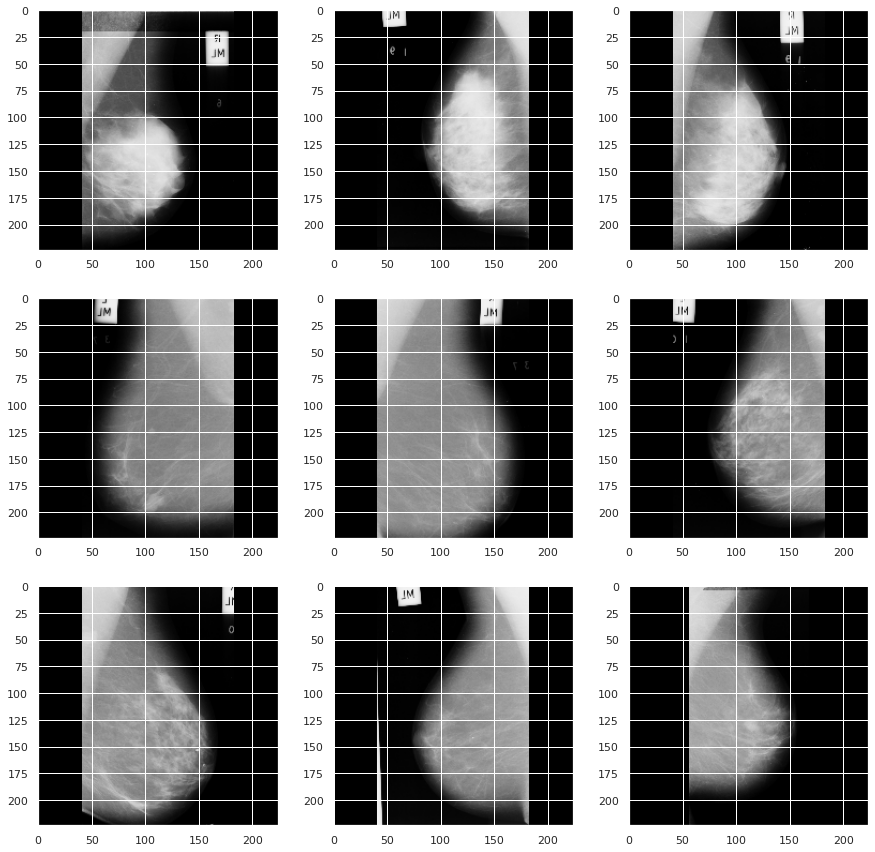

In [8]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("../content/drive/MyDrive/Colab Notebooks/Dataset/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [9]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
    return (info)

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

NameError: ignored

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [25]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=100, batch_size=128,callbacks=[es])

Epoch 1/100
30/30 [==============================] - 41s 1s/step - loss: 0.7396 - accuracy: 0.6170 - val_loss: 2.5267 - val_accuracy: 0.7212
Epoch 2/100
30/30 [==============================] - 39s 1s/step - loss: 0.2225 - accuracy: 0.9084 - val_loss: 0.9424 - val_accuracy: 0.8348
Epoch 3/100
30/30 [==============================] - 39s 1s/step - loss: 0.0690 - accuracy: 0.9732 - val_loss: 0.5060 - val_accuracy: 0.8894
Epoch 4/100
30/30 [==============================] - 39s 1s/step - loss: 0.0796 - accuracy: 0.9691 - val_loss: 0.3379 - val_accuracy: 0.9273
Epoch 5/100
30/30 [==============================] - 39s 1s/step - loss: 0.0421 - accuracy: 0.9831 - val_loss: 0.2809 - val_accuracy: 0.9424
Epoch 6/100
30/30 [==============================] - 39s 1s/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0.1860 - val_accuracy: 0.9455
Epoch 7/100
30/30 [==============================] - 39s 1s/step - loss: 0.0236 - accuracy: 0.9927 - val_loss: 0.1410 - val_accuracy: 0.9606
Epoch 8/100
3

In [26]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

print(model.predict(x_test))
model.save(url+'breast_cancer_model.h5')

save_dictionary('history1.dat', history.history)

25/25 [==============================] - 7s 279ms/step - loss: 0.1519 - accuracy: 0.9524
Test_loss_value = 0.1519239991903305
test_accuracy = 0.9523809552192688
[[9.99801695e-01]
 [9.99999881e-01]
 [3.88636254e-04]
 [1.20686120e-04]
 [3.23080836e-04]
 [9.99997616e-01]
 [1.51560071e-05]
 [9.99999046e-01]
 [2.20129179e-04]
 [2.30132067e-03]
 [2.23846182e-05]
 [8.40011489e-06]
 [5.33835441e-02]
 [5.61345150e-05]
 [9.99968171e-01]
 [2.80905533e-06]
 [3.65313441e-02]
 [9.99981880e-01]
 [1.12745329e-06]
 [2.59363696e-06]
 [6.69333360e-07]
 [5.59869151e-10]
 [9.99999046e-01]
 [9.98393357e-01]
 [6.08801958e-04]
 [9.99994397e-01]
 [9.99994874e-01]
 [9.69685435e-01]
 [9.99994397e-01]
 [1.80407824e-07]
 [1.00000000e+00]
 [9.99912858e-01]
 [6.22050464e-01]
 [9.99999642e-01]
 [8.17047060e-01]
 [9.99992132e-01]
 [3.05534763e-06]
 [1.85927695e-06]
 [7.25978136e-01]
 [1.00000000e+00]
 [3.78438947e-03]
 [1.00000000e+00]
 [9.88467097e-01]
 [1.00000000e+00]
 [9.99999881e-01]
 [1.36911357e-03]
 [9.0233459

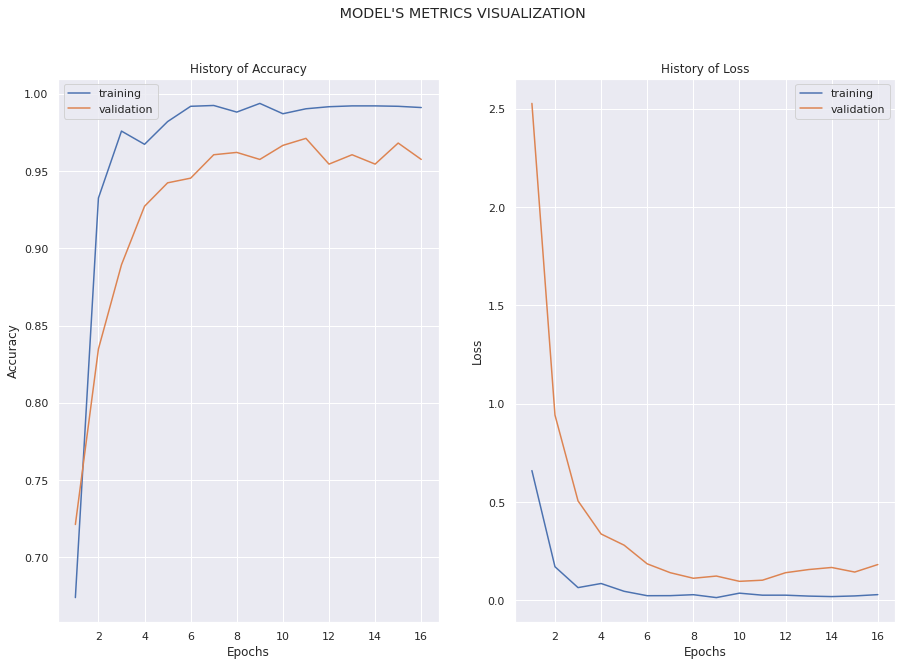

In [27]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [29]:
y_pred=model.predict_classes(x_test)
y_pred_prb=model.predict_proba(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [30]:
# def print_performance_metrics(y_test,y_pred):
#     """
#         parameters
#         ----------
#         y_test : actual label (must be in non-one hot encoded form)
#         y_pred_test : predicted labels (must be in non-one hot encoded form, common output of predict methods of classifers)

#         returns
#         -------
#         prints the accuracy, precision, recall, F1 score, ROC AUC score, Cohen Kappa Score, Matthews Corrcoef and classification report   
    
#     """
target=["B","M"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.9524
Precision: 0.9539
Recall: 0.9524
F1 Score: 0.9524
ROC AUC Score: 0.993
Cohen Kappa Score: 0.9046
		Classification Report:
               precision    recall  f1-score   support

           B       0.98      0.93      0.95       418
           M       0.92      0.98      0.95       359

    accuracy                           0.95       777
   macro avg       0.95      0.95      0.95       777
weighted avg       0.95      0.95      0.95       777

